# Non-final Notebook


 - Explore your telco data to discover drivers of churn
 - Determine if certain columns should be dropped
 - Determine if it would be valuable to bin some numeric columns
 - Determine if it would be valuable to combine multiple columns into one.

What are your drivers of churn?

Does it make sense to combine any features?

Do you find any surprises?

Document any and all findings and takeaways in your notebook using markdown.

In [1]:
#data manipulations
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os
 
#stats
from scipy import stats

#my own files with my own functions
import acquire
import prepare
import explore

# train test split function and models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

#### Acquire phase

In [2]:
# acquire data
df = acquire.get_telco_data()

#### Prepare phase

In [3]:
# prepare data with function from prepare module
df = prepare.prep_telco(df)

In [4]:
df.sample(3)

,gender,senior_citizen,partner,dependents,phone_service_type,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,total_add_on_count,tenure_years
customer_id,,,,,,,,,,,,,,
2528-HFYZX,Male,Yes,Yes,No,Single line,Yes,76.45,1233.40,Yes,Month-to-month,Fiber optic,Electronic check,1,1
1470-PSXNM,Male,No,Yes,Yes,Multiple lines,Yes,93.65,4520.15,No,One year,Fiber optic,Electronic check,3,4
2804-ETQDK,Male,No,No,Yes,Single line,No,20.55,1357.10,No,Two year,No internet service,Mailed check,No internet service,5


In [5]:
# split data with function from prepare module with churn as the target variable
train, validate, test = prepare.split_data(df, 'churn')

train: 4225 (60.0% of 7043)
validate: 1409 (20.0% of 7043)
test: 1409 (20.0% of 7043)


#### Explore phase
 - Only use train data during this phase

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 4083-BFNYK to 7562-UXTPG
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gender                 4225 non-null   object  
 1   senior_citizen         4225 non-null   object  
 2   partner                4225 non-null   object  
 3   dependents             4225 non-null   object  
 4   phone_service_type     4225 non-null   object  
 5   paperless_billing      4225 non-null   object  
 6   monthly_charges        4225 non-null   float64 
 7   total_charges          4225 non-null   float64 
 8   churn                  4225 non-null   object  
 9   contract_type          4225 non-null   object  
 10  internet_service_type  4225 non-null   object  
 11  payment_type           4225 non-null   object  
 12  total_add_on_count     4225 non-null   object  
 13  tenure_years           4225 non-null   category
dtypes: category(1), float64(2), ob

In [7]:
train.paperless_billing.value_counts()

paperless_billing
Yes    2507
No     1718
Name: count, dtype: int64

In [8]:
train.internet_service_type.value_counts()

internet_service_type
Fiber optic            1898
DSL                    1409
No internet service     918
Name: count, dtype: int64

In [9]:
train.payment_type.value_counts()

payment_type
Electronic check             1434
Mailed check                  935
Bank transfer (automatic)     935
Credit card (automatic)       921
Name: count, dtype: int64

In [10]:
train.head(3)

,gender,senior_citizen,partner,dependents,phone_service_type,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,total_add_on_count,tenure_years
customer_id,,,,,,,,,,,,,,
4083-BFNYK,Female,Yes,Yes,No,Multiple lines,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic),3,3
5804-LEPIM,Female,Yes,No,No,Single line,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check,0,0
4895-TMWIR,Male,Yes,Yes,No,Single line,No,19.95,214.75,Yes,Month-to-month,No internet service,Mailed check,No internet service,0


After splitting data, I can now separate variables into two categories: continuous and categorical

In [11]:
# make two lists, one with all categorical variables and another with all continouus vairables
#intializing empty lists
cat_col = []
con_col = []

#looping through all columns
for col in train.columns:
        #finding all my categorical columns by checking for how many unique values
        # if less than 100, append to cat_col
        if train[col].nunique() < 50:
            cat_col.append(col)
        else: 
            #if it has more than 100 unique values, append to continous column variable
            con_col.append(col)

In [12]:
# check lists
cat_col 

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service_type',
 'paperless_billing',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'total_add_on_count',
 'tenure_years']

In [13]:
con_col

['monthly_charges', 'total_charges']

a for loop can prints contingency tables with features vs target 

In [14]:
# Target variable is churn
target_variable = 'churn'

# Initialize an empty list to store columns for comparison
columns_to_compare = []

# Create a for loop to iterate through each column in the categorical column list
# appending our comparision list as long as the column is not churn
for column in cat_col:
    if column != target_variable:
        columns_to_compare.append(column)
    else:
        pass

In [15]:
columns_to_compare

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service_type',
 'paperless_billing',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'total_add_on_count',
 'tenure_years']


Contingency Table for gender vs. churn:

churn     No  Yes
gender           
Female  1550  559
Male    1554  562


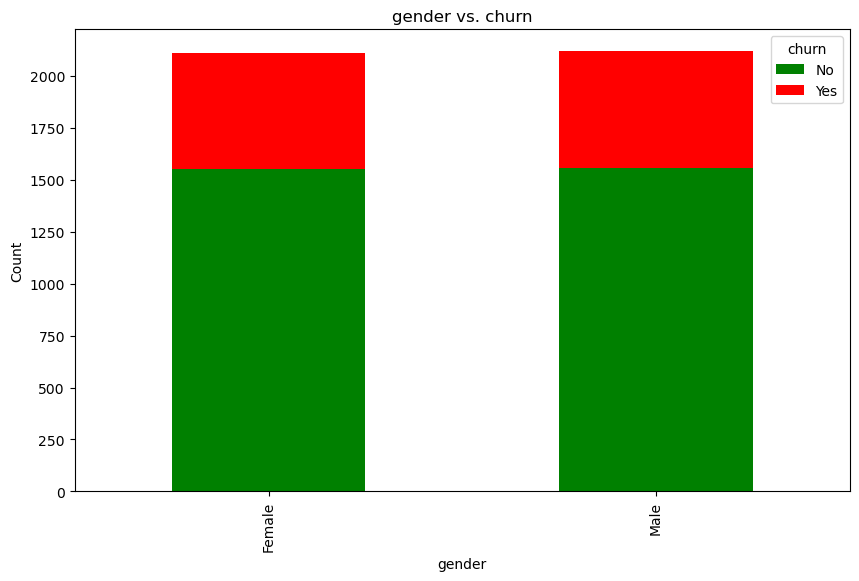


Contingency Table for senior_citizen vs. churn:

churn             No  Yes
senior_citizen           
No              2696  835
Yes              408  286


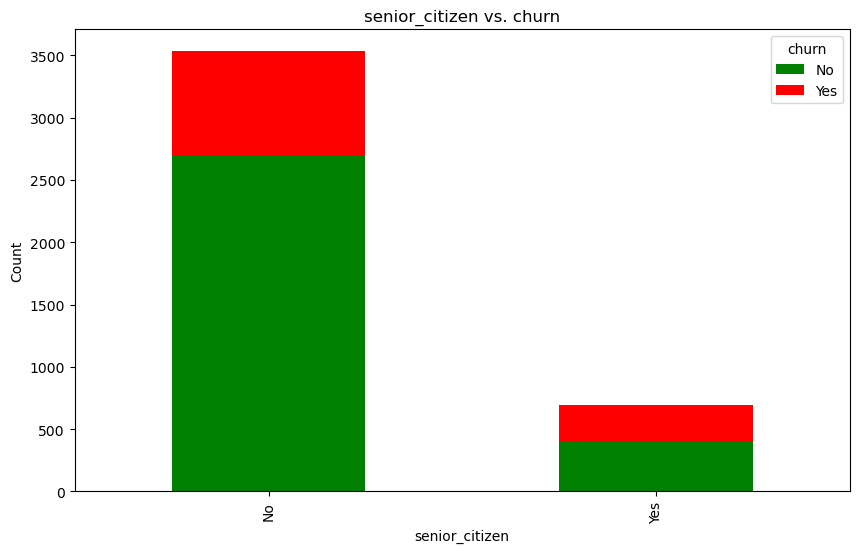


Contingency Table for partner vs. churn:

churn      No  Yes
partner           
No       1445  715
Yes      1659  406


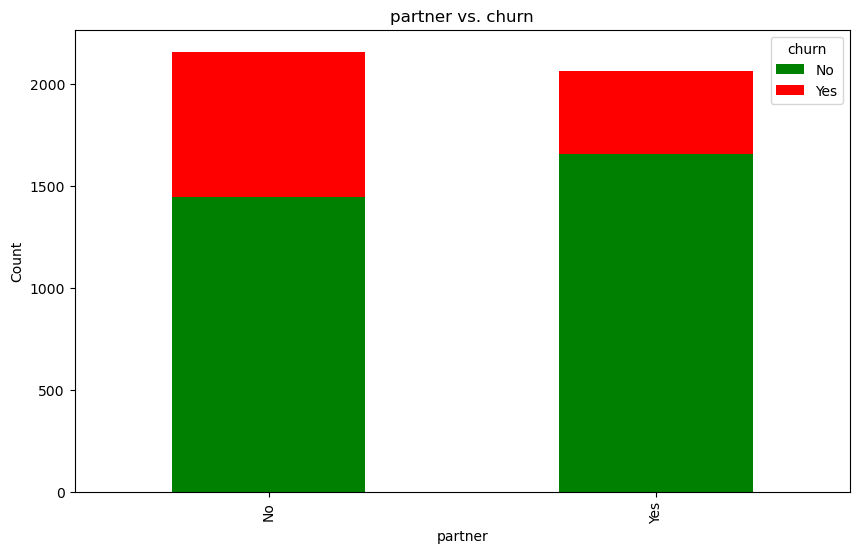


Contingency Table for dependents vs. churn:

churn         No  Yes
dependents           
No          2042  919
Yes         1062  202


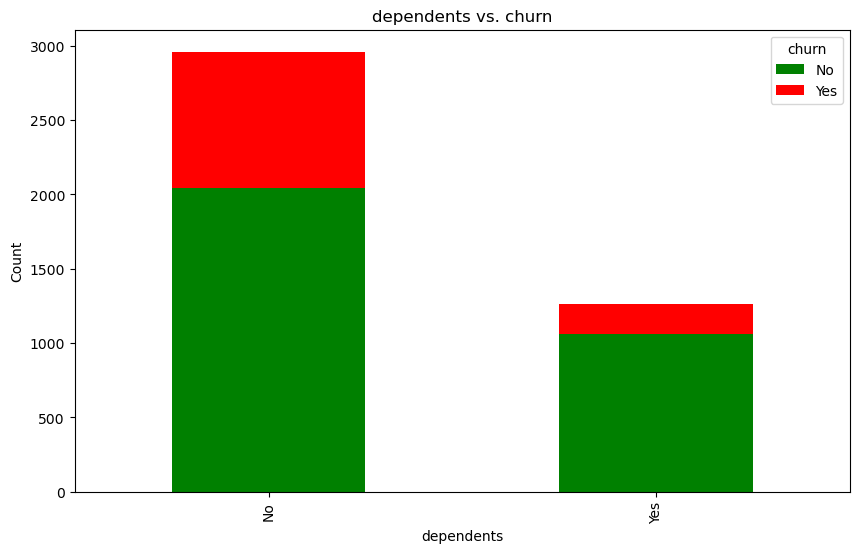


Contingency Table for phone_service_type vs. churn:

churn                 No  Yes
phone_service_type           
Multiple lines      1309  502
No phone service     295   99
Single line         1500  520


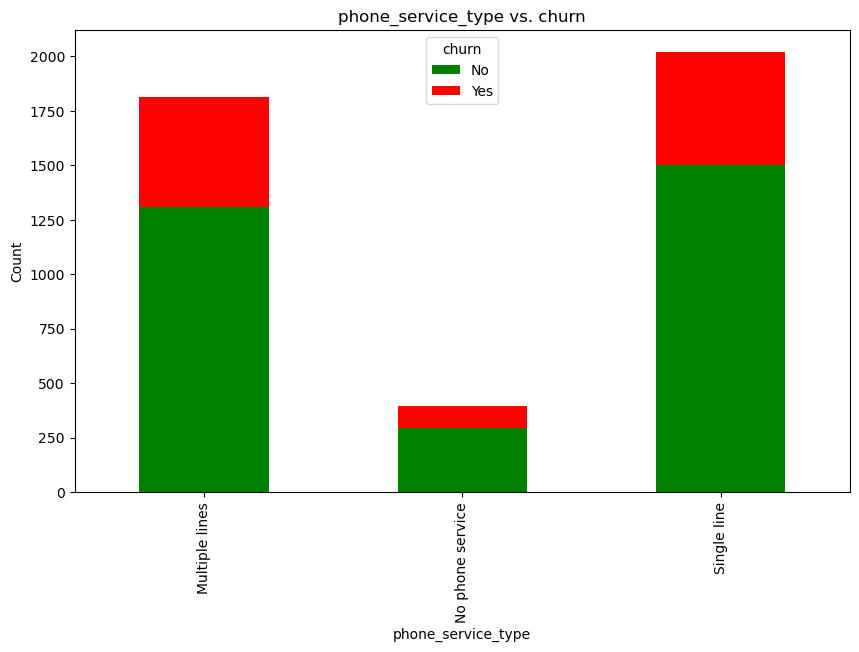


Contingency Table for paperless_billing vs. churn:

churn                No  Yes
paperless_billing           
No                 1437  281
Yes                1667  840


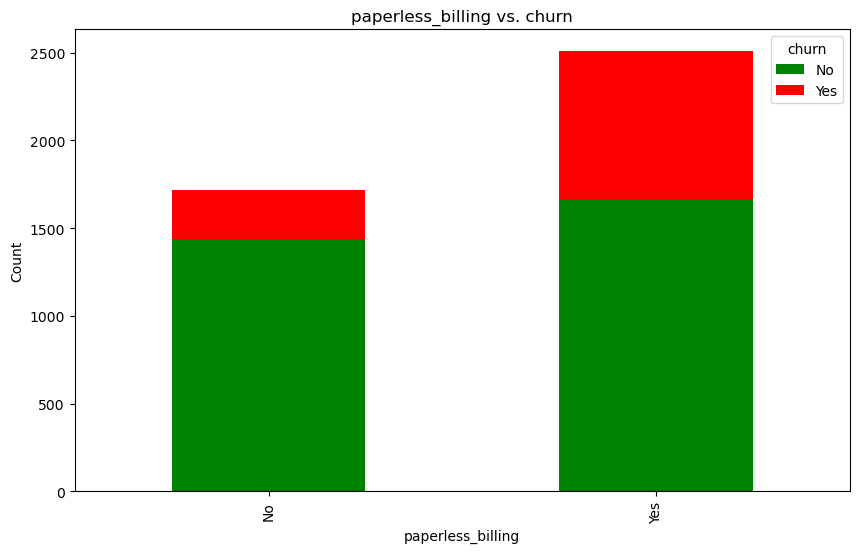


Contingency Table for contract_type vs. churn:

churn             No  Yes
contract_type            
Month-to-month  1338  997
One year         785   94
Two year         981   30


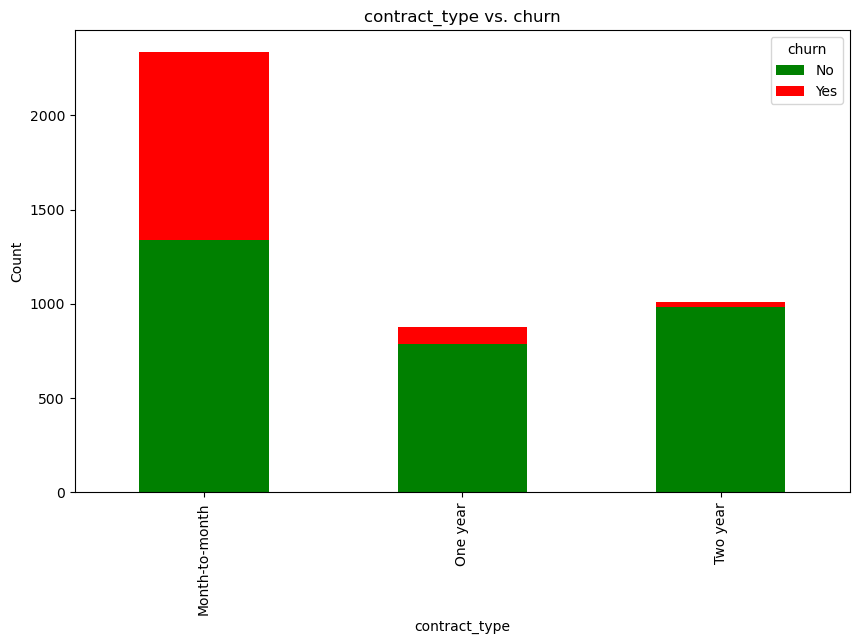


Contingency Table for internet_service_type vs. churn:

churn                    No  Yes
internet_service_type           
DSL                    1140  269
Fiber optic            1116  782
No internet service     848   70


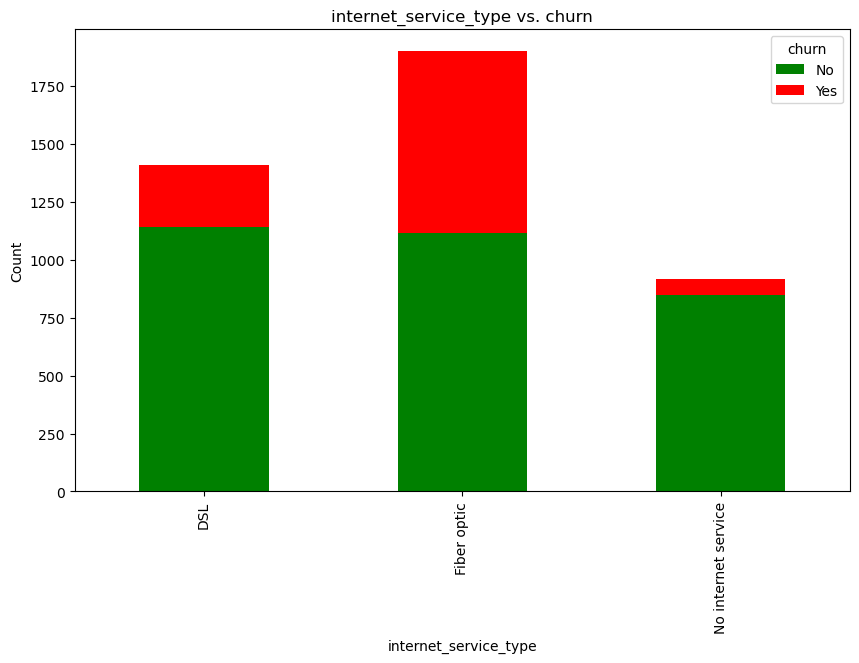


Contingency Table for payment_type vs. churn:

churn                       No  Yes
payment_type                       
Bank transfer (automatic)  778  157
Credit card (automatic)    783  138
Electronic check           788  646
Mailed check               755  180


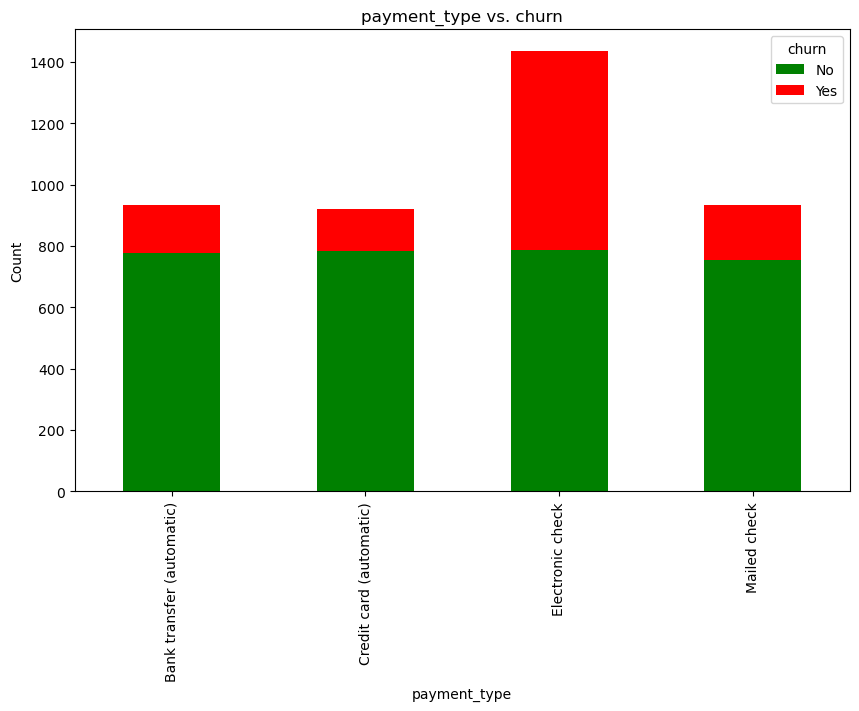


Contingency Table for total_add_on_count vs. churn:

churn                 No  Yes
total_add_on_count           
0                    188  221
1                    320  251
2                    382  220
3                    504  196
4                    403  111
5                    303   41
6                    156   11
No internet service  848   70


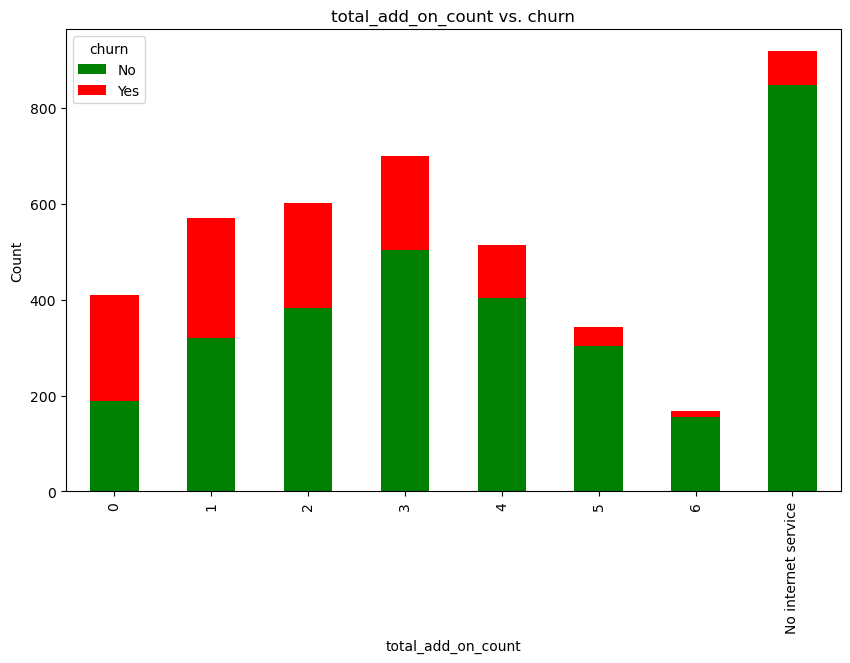


Contingency Table for tenure_years vs. churn:

churn          No  Yes
tenure_years          
0             626  609
1             448  164
2             422  110
3             343   95
4             417   89
5             620   49
6             228    5


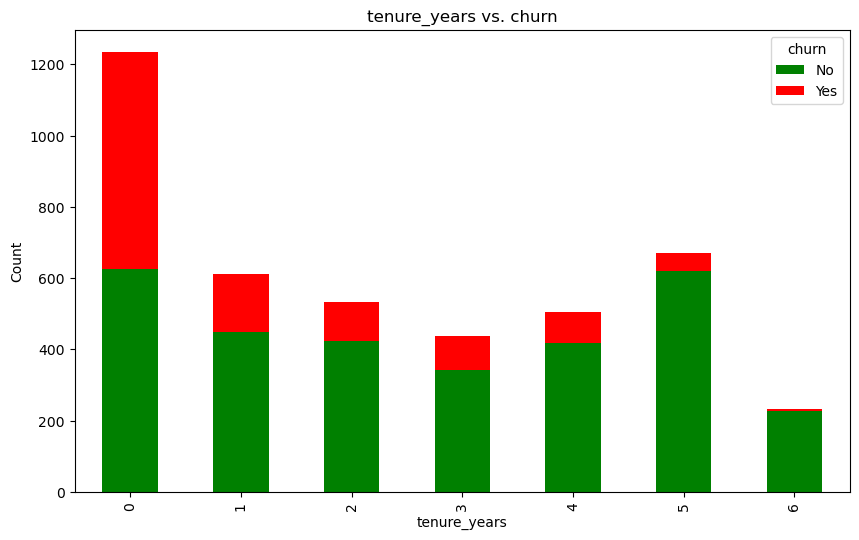

In [16]:
# For loop to create contingency table and bar plot for each comparision column vs churn
# describe and visualize the distribution of categorical variables and make inferences about 
# the equality of proportions, independence of the variables, or agreement between variables.
for column in columns_to_compare:
    # Create a contingency table
    contingency_table = pd.crosstab(train[column], train[target_variable])
    
    # Display the contingency table
    print(f"\nContingency Table for {column} vs. {target_variable}:\n")
    print(contingency_table)
    
    # To help visualize the contingency table, we can use a stacked bar plot
    contingency_table.plot.bar(stacked=True, color=['green', 'red'], figsize=(10, 6))
    plt.title(f'{column} vs. {target_variable}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

Box plot to view continuous variables vs target variable

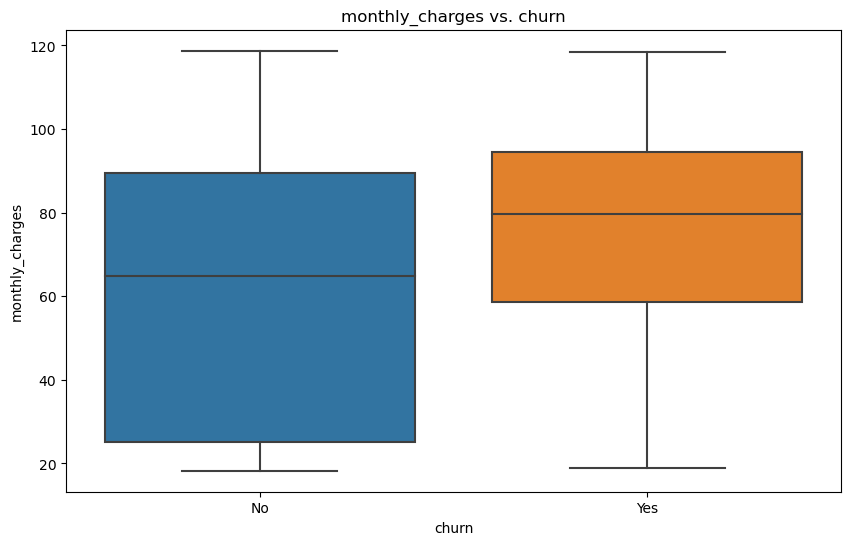

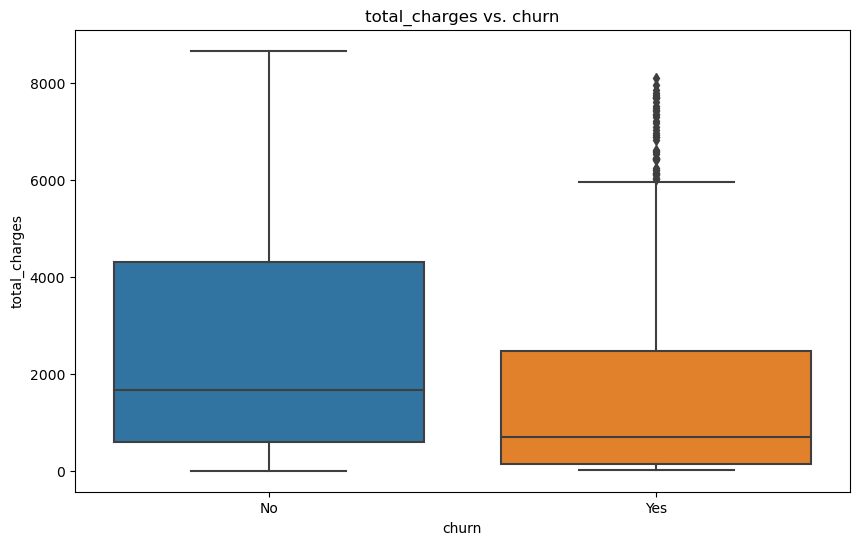

In [17]:
# Target variable
target_variable = 'churn'

# Create a for loop to compare each continuous variable to the target variable
for column in con_col:
    # Visualize the distribution of the continuous variable 
    plt.figure(figsize=(10, 6))
    # Box plot with target variable and count
    sns.boxplot(x=target_variable, y=column, data=train)
    plt.title(f'{column} vs. {target_variable}')
    plt.xlabel(target_variable)
    plt.ylabel(column)
    plt.show()

In [18]:
train

,gender,senior_citizen,partner,dependents,phone_service_type,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,total_add_on_count,tenure_years
customer_id,,,,,,,,,,,,,,
4083-BFNYK,Female,Yes,Yes,No,Multiple lines,No,95.00,3591.25,No,One year,Fiber optic,Credit card (automatic),3,3
5804-LEPIM,Female,Yes,No,No,Single line,Yes,70.35,139.05,Yes,Month-to-month,Fiber optic,Electronic check,0,0
4895-TMWIR,Male,Yes,Yes,No,Single line,No,19.95,214.75,Yes,Month-to-month,No internet service,Mailed check,No internet service,0
1342-JPNKI,Male,No,No,No,Multiple lines,Yes,86.05,834.10,Yes,Month-to-month,Fiber optic,Bank transfer (automatic),1,0
3397-AVTKU,Male,No,No,No,Single line,Yes,60.00,2548.55,No,Two year,DSL,Electronic check,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915-IOFGU,Female,No,No,No,Single line,No,70.50,70.50,Yes,Month-to-month,Fiber optic,Electronic check,0,0
7025-WCBNE,Male,Yes,No,No,Multiple lines,No,59.60,2754.00,No,Two year,DSL,Bank transfer (automatic),2,3
9788-HNGUT,Male,No,Yes,No,Multiple lines,Yes,116.95,8594.40,No,Two year,Fiber optic,Credit card (automatic),6,6


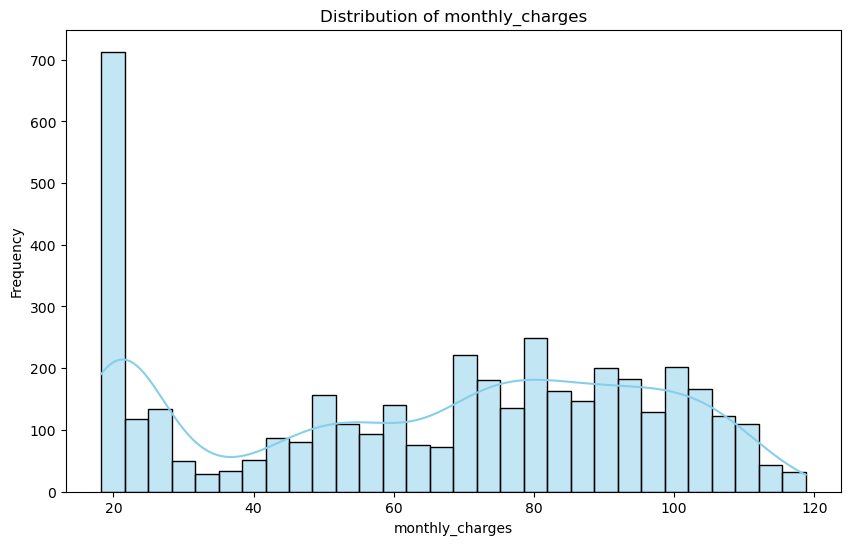

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting a histogram with kernel density estimation
plt.figure(figsize=(10, 6))
sns.histplot(train['monthly_charges'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of monthly_charges')
plt.xlabel('monthly_charges')
plt.ylabel('Frequency')
plt.show()

In [20]:
train.monthly_charges.value_counts()


monthly_charges
20.05     43
19.85     29
19.90     29
19.70     28
20.35     27
          ..
108.65     1
43.45      1
101.55     1
46.05      1
116.95     1
Name: count, Length: 1374, dtype: int64

In [21]:
average_monthly_charges = train.groupby('contract_type')['monthly_charges'].mean()
print(average_monthly_charges)


contract_type
Month-to-month    66.713897
One year          66.116155
Two year          60.651830
Name: monthly_charges, dtype: float64


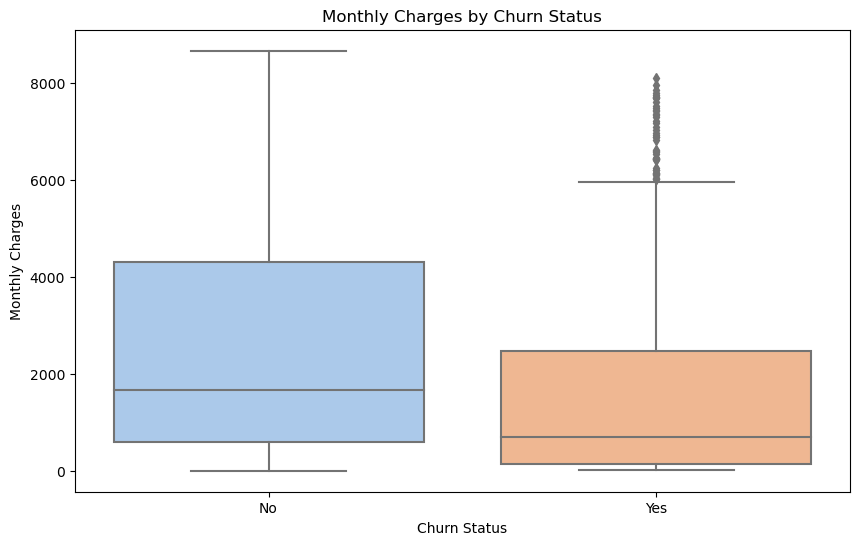

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='total_charges', data=train, palette='pastel')
plt.title('Monthly Charges by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Monthly Charges')
plt.show()


In [23]:
churned_charges = train[train['churn'] == 'Yes']['monthly_charges']
not_churned_charges = train[train['churn'] == 'No']['monthly_charges']

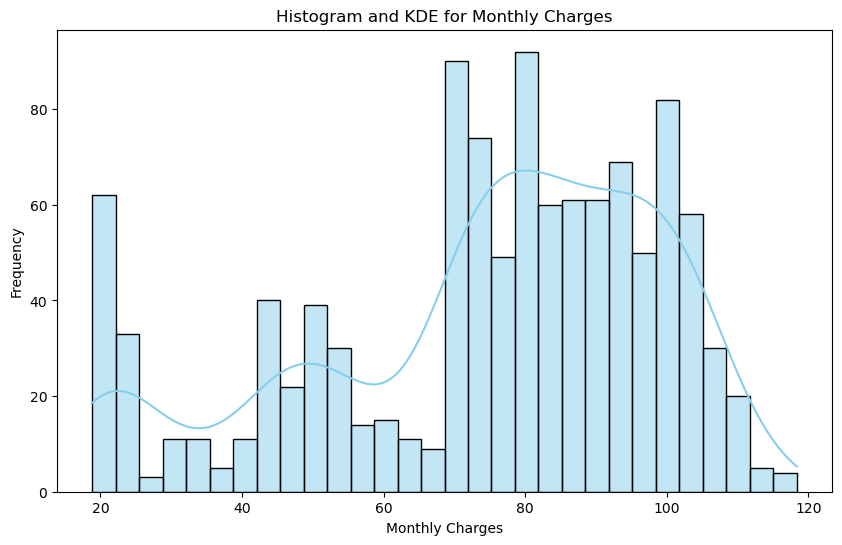

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Histogram for MonthlyCharges
plt.figure(figsize=(10, 6))
sns.histplot(churned_charges, kde=True, color='skyblue', bins=30)
plt.title('Histogram and KDE for Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()



In [25]:
from scipy.stats import shapiro

# Shapiro-Wilk test for normality
stat, p_value = shapiro(train['monthly_charges'])
print(f'Shapiro-Wilk Test - Statistic: {stat}, p-value: {p_value}')


Shapiro-Wilk Test - Statistic: 0.9185670018196106, p-value: 5.647232811229013e-43


In [26]:
from scipy.stats import mannwhitneyu

t_stat, p_value = mannwhitneyu(churned_charges, not_churned_charges)


In [27]:
t_stat, p_value

(2136241.0, 9.83259830397179e-30)

> investegating relationships between features and target 

### FIRST RELATIONSHIP

 1. Hypothesize

Q: does payment type affect whether or not someone churned?

In [28]:
train.payment_type.value_counts()

payment_type
Electronic check             1434
Mailed check                  935
Bank transfer (automatic)     935
Credit card (automatic)       921
Name: count, dtype: int64

In [29]:
train.churn.value_counts()

churn
No     3104
Yes    1121
Name: count, dtype: int64

2. Visualize

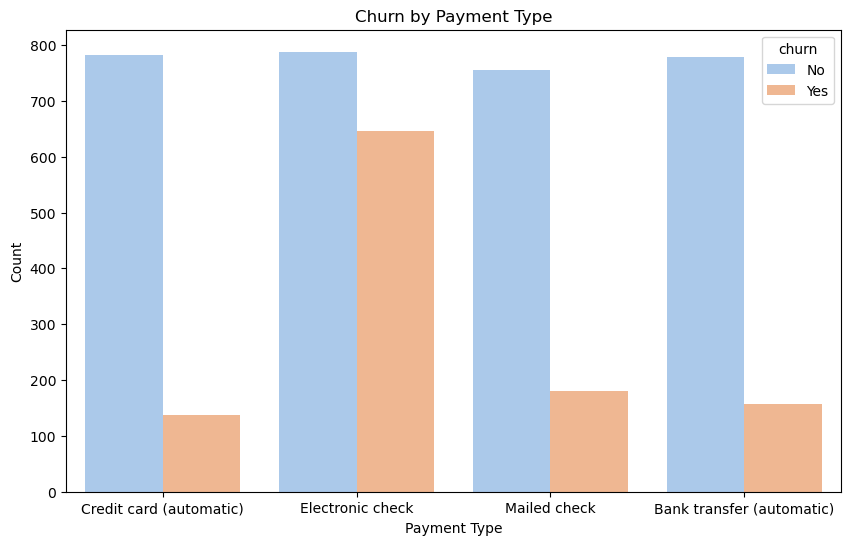

In [30]:
# customers with electronic check payment types churned a lot
plt.figure(figsize=(10, 6))
sns. countplot(x='payment_type', hue='churn', data=train, palette='pastel')
plt.title('Churn by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.show()

> customers with electronic check payment type churned a lot more than other payment types. 

3. Analyze with stats

two categorical variables:  use chi^2

In [31]:
# make hypothesis and set significance level 

$H_0$: There is no relationship between payment type and whether or not someone has churned

$H_a$: There is a relationship between payment type and whether or not someone has churned

In [32]:
alpha = 0.05

In [33]:
# create crosstab
observed = pd.crosstab(train.churn, train.payment_type)

In [34]:
observed

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
No,778,783,788,755
Yes,157,138,646,180


In [35]:
#chi2_contingency prints out 4 values - chi2, p-value, degrees of freedom, and expected values
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [36]:
#output values
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[778 783 788 755]
 [157 138 646 180]]

Expected
[[ 686  676 1053  686]
 [ 248  244  380  248]]

----
chi^2 = 386.1840
p     = 0.0000


In [37]:
# State your conclusion
#compare our p-value and alpha
if p < alpha:
    print('reject the null hypothesis')
else:
    print('fail to reject the null hypothesis')


reject the null hypothesis


In [38]:
# we reject the null hypothesis
# There is a relationship between payment type and whether or not someone churned

4. Summarize

One particular type of payment method shows a lot of customer churn. Maybe this is due to some factor related to costs, fees, or delivery speed. Will need to investigate further asking are there fees associated with each payment type, what are their delivery speeds?

### Second Relationship

 1. Hypothesize

Q: does contract type affect whether or not someone has churned?

What are churn and contract type? Two categorical variables.

In [39]:
train.contract_type.value_counts()

contract_type
Month-to-month    2335
Two year          1011
One year           879
Name: count, dtype: int64

In [40]:
train.churn.value_counts()

churn
No     3104
Yes    1121
Name: count, dtype: int64

2. Visualize

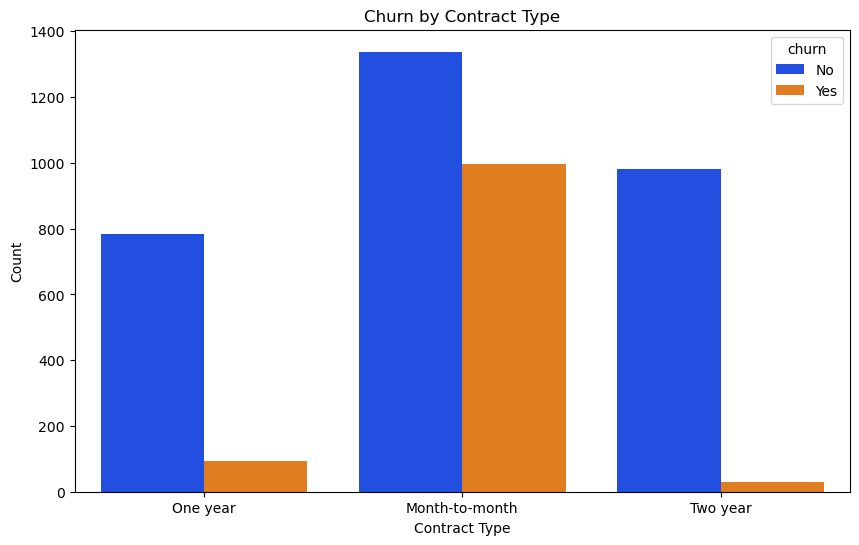

In [41]:
# customers with month to month contract types churned a lot
plt.figure(figsize=(10, 6))
sns. countplot(x='contract_type', hue='churn', data=train, palette='bright')
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()

> customers with month to month contract types churn mroe than other contract types

3. Analyze with stats

two categorical variables, we can use chi^2

In [42]:
# make hypothesis and set significance level 

$H_0$: There is no relationship between contract type and whether or not someone has churned

$H_a$: There is a relationship between contract type and whether or not someone has churned

In [43]:
alpha = 0.05

In [44]:
# create crosstab
observed_ct = pd.crosstab(train.churn, train.contract_type)
observed_ct

contract_type,Month-to-month,One year,Two year
churn,,,
No,1338,785,981
Yes,997,94,30


In [45]:
#chi2_contingency prints out 4 values - chi2, p-value, degrees of freedom, and expected values
chi2, p, dof, expected = stats.chi2_contingency(observed_ct)

In [46]:
#output values
print('Observed')
print(observed_ct.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1338  785  981]
 [ 997   94   30]]

Expected
[[1715  645  742]
 [ 619  233  268]]

----
chi^2 = 714.1745
p     = 0.0000


In [47]:
# State your conclusion
#compare our p-value and alpha
if p < alpha:
    print('reject the null hypothesis')
else:
    print('fail to reject the null hypothesis')


reject the null hypothesis


In [48]:
# we reject the null hypothesis
# There is a relationship between contract type and whether or not someone churned

4. Summarize

One particular contract type (month-to-month) has a lot of customers with churned status. This would make sense becuase people with long contracts can not churn as easily as customers with month to month contracts. However, I would like to examine if contract type and tenure relates to churn. 

### Third Relationship

 1. Hypothesize

Q: does tenure affect whether or not someone has churned?

What are churn and tenure? One categorical variable and one continuous variable? Maybe, unless we bin tenure into years instead of months.

In [49]:
train.tenure_years.value_counts()

tenure_years
0    1235
5     669
1     612
2     532
4     506
3     438
6     233
Name: count, dtype: int64

In [50]:
train.churn.value_counts()

churn
No     3104
Yes    1121
Name: count, dtype: int64

2. Visualize

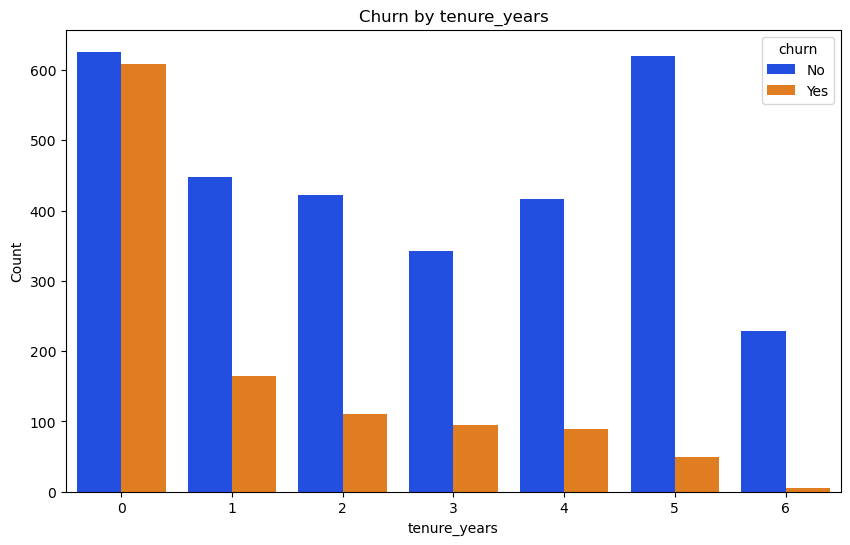

In [51]:
# customers with month to month contract types churned a lot
plt.figure(figsize=(10, 6))
sns. countplot(x='tenure_years', hue='churn', data=train, palette='bright')
plt.title('Churn by tenure_years')
plt.xlabel('tenure_years')
plt.ylabel('Count')
plt.show()

> it appears customers are churning early on in their tenure. Customers who have stayed with telco are still with telco

3. Analyze with statistics

comparing categorical to categorical because we are going to bin tenure into years, of which the higest tenure is 72 months.

In [52]:
observed_tenure = pd.crosstab(train.churn, train.tenure_years)
observed_tenure

tenure_years,0,1,2,3,4,5,6
churn,,,,,,,
No,626,448,422,343,417,620,228
Yes,609,164,110,95,89,49,5


two categorical variables, we can use chi^2

In [53]:
# make hypothesis and set significance level 

$H_0$: There is no relationship between tenure and whether or not someone has churned

$H_a$: There is a relationship between tenure and whether or not someone has churned

In [54]:
alpha = 0.05

In [55]:
#chi2_contingency prints out 4 values - chi2, p-value, degrees of freedom, and expected values
chi2, p, dof, expected = stats.chi2_contingency(observed_tenure)

In [56]:
#output values
print('Observed')
print(observed_tenure.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[626 448 422 343 417 620 228]
 [609 164 110  95  89  49   5]]

Expected
[[907 449 390 321 371 491 171]
 [327 162 141 116 134 177  61]]

----
chi^2 = 561.8805
p     = 0.0000


In [57]:
# State your conclusion
#compare our p-value and alpha
if p < alpha:
    print('reject the null hypothesis')
else:
    print('fail to reject the null hypothesis')

reject the null hypothesis


In [58]:
# we reject the null hypothesis
# There is a relationship between tenure and whether or not someone churned

4. Summarize

People are churning early on in their tenure. I would like to explore the differences between customers at the tenure value where most leave.

## Modeling

When done with exploring, you have to encode and prepare all three splits for ML.

In [59]:
# preprocess, get our 3 dataframes ready for ML
train, validate, test = prepare.preprocess_telco(train, validate, test)

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 4083-BFNYK to 7562-UXTPG
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   gender                                4225 non-null   int64  
 1   senior_citizen                        4225 non-null   int64  
 2   partner                               4225 non-null   int64  
 3   dependents                            4225 non-null   int64  
 4   paperless_billing                     4225 non-null   int64  
 5   monthly_charges                       4225 non-null   float64
 6   total_charges                         4225 non-null   float64
 7   churn                                 4225 non-null   int64  
 8   total_add_on_count                    4225 non-null   int64  
 9   tenure_years                          4225 non-null   int64  
 10  contract_type_One year                4225 non-null   int64  
 11  contrac

In [61]:
train.T


customer_id,4083-BFNYK,5804-LEPIM,4895-TMWIR,1342-JPNKI,3397-AVTKU,1051-EQPZR,4193-ORFCL,1354-YZFNB,0442-TDYUO,1264-BYWMS,...,5959-BELXA,6897-UUBNU,9444-JTXHZ,0617-FHSGK,0330-BGYZE,1915-IOFGU,7025-WCBNE,9788-HNGUT,5229-PRWKT,7562-UXTPG
gender,0.00,0.00,1.00,1.00,1.00,0.00,0.0,1.00,1.00,1.00,...,1.00,1.00,1.0,1.0,1.0,0.0,1.0,1.00,1.00,0.00
senior_citizen,1.00,1.00,1.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,...,1.00,0.00,0.0,0.0,0.0,0.0,1.0,0.00,0.00,0.00
partner,1.00,0.00,1.00,0.00,0.00,1.00,0.0,1.00,1.00,0.00,...,0.00,0.00,1.0,0.0,1.0,0.0,0.0,1.00,0.00,0.00
dependents,0.00,0.00,0.00,0.00,0.00,1.00,0.0,1.00,0.00,0.00,...,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.00,0.00,0.00
paperless_billing,0.00,1.00,0.00,1.00,1.00,0.00,0.0,0.00,1.00,1.00,...,1.00,0.00,0.0,0.0,0.0,0.0,0.0,1.00,1.00,1.00
monthly_charges,95.00,70.35,19.95,86.05,60.00,19.60,45.1,19.55,20.05,96.80,...,96.15,89.65,76.2,75.2,102.5,70.5,59.6,116.95,86.55,70.15
total_charges,3591.25,139.05,214.75,834.10,2548.55,780.25,45.1,68.80,1036.00,5283.95,...,3019.25,2623.65,76.2,3678.3,6157.6,70.5,2754.0,8594.40,649.65,886.70
churn,0.00,1.00,1.00,1.00,0.00,0.00,1.0,0.00,0.00,1.00,...,1.00,0.00,1.0,1.0,0.0,1.0,0.0,0.00,1.00,0.00
total_add_on_count,3.00,0.00,0.00,1.00,2.00,0.00,0.0,0.00,0.00,2.00,...,2.00,3.00,1.0,0.0,4.0,0.0,2.0,6.00,1.00,0.00
tenure_years,3.00,0.00,0.00,0.00,3.00,3.00,0.0,0.00,4.00,4.00,...,2.00,2.00,0.0,4.0,5.0,0.0,3.0,6.00,0.00,1.00


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 4083-BFNYK to 7562-UXTPG
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   gender                                4225 non-null   int64  
 1   senior_citizen                        4225 non-null   int64  
 2   partner                               4225 non-null   int64  
 3   dependents                            4225 non-null   int64  
 4   paperless_billing                     4225 non-null   int64  
 5   monthly_charges                       4225 non-null   float64
 6   total_charges                         4225 non-null   float64
 7   churn                                 4225 non-null   int64  
 8   total_add_on_count                    4225 non-null   int64  
 9   tenure_years                          4225 non-null   int64  
 10  contract_type_One year                4225 non-null   int64  
 11  contrac

## Testing models

In [63]:
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

Desicion Tree

In [64]:
# change hyperparameters
scores_all = []

for x in range(1,11):
    
    clf = DecisionTreeClassifier(min_samples_leaf= x, max_depth=11-x, random_state=123)
    clf = clf.fit(X_train, y_train)
    
    # evaluate on train
    train_acc = clf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = clf.score(X_validate, y_validate)
    print(f'min_samples_leaf= {x}, max_depth = {11-x}, accuracy={train_acc, val_acc}')

min_samples_leaf= 1, max_depth = 10, accuracy=(0.8769230769230769, 0.7714691270404542)
min_samples_leaf= 2, max_depth = 9, accuracy=(0.8501775147928994, 0.7721788502484032)
min_samples_leaf= 3, max_depth = 8, accuracy=(0.8355029585798817, 0.7821149751596878)
min_samples_leaf= 4, max_depth = 7, accuracy=(0.8196449704142011, 0.7913413768630234)
min_samples_leaf= 5, max_depth = 6, accuracy=(0.8099408284023669, 0.7821149751596878)
min_samples_leaf= 6, max_depth = 5, accuracy=(0.797396449704142, 0.7849538679914834)
min_samples_leaf= 7, max_depth = 4, accuracy=(0.7910059171597633, 0.7828246983676366)
min_samples_leaf= 8, max_depth = 3, accuracy=(0.7841420118343195, 0.7863733144073811)
min_samples_leaf= 9, max_depth = 2, accuracy=(0.7841420118343195, 0.7863733144073811)
min_samples_leaf= 10, max_depth = 1, accuracy=(0.7346745562130178, 0.7345635202271115)


> max depth  and 4 leafs is the best tunned model

Random Forest

In [65]:
# change parameters
scores_all = []

for x in range(1,11):

    rf = RandomForestClassifier(min_samples_leaf= x, max_depth=11-x, random_state=123)
    rf= rf.fit(X_train, y_train)
    
    # evaluate on train
    train_acc = rf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = rf.score(X_validate, y_validate)
    print(f'min_samples_leaf= {x} max_depth = {11-x}, accuracy={train_acc, val_acc}')

min_samples_leaf= 1 max_depth = 10, accuracy=(0.8809467455621302, 0.794889992902768)
min_samples_leaf= 2 max_depth = 9, accuracy=(0.8497041420118343, 0.7920511000709723)
min_samples_leaf= 3 max_depth = 8, accuracy=(0.829112426035503, 0.8019872249822569)
min_samples_leaf= 4 max_depth = 7, accuracy=(0.816094674556213, 0.8034066713981547)
min_samples_leaf= 5 max_depth = 6, accuracy=(0.8049704142011834, 0.8034066713981547)
min_samples_leaf= 6 max_depth = 5, accuracy=(0.7995266272189349, 0.7963094393186657)
min_samples_leaf= 7 max_depth = 4, accuracy=(0.7936094674556213, 0.7934705464868701)
min_samples_leaf= 8 max_depth = 3, accuracy=(0.7846153846153846, 0.7856635911994322)
min_samples_leaf= 9 max_depth = 2, accuracy=(0.7737278106508876, 0.7622427253371186)
min_samples_leaf= 10 max_depth = 1, accuracy=(0.7346745562130178, 0.7345635202271115)


> max depth 6 and 5 leafs is the best tunned model

Export files to csv

In [66]:
# train.to_csv('file1.csv')

In [67]:
### Is there a relationship between monthly charges and whether or not a customer has churned?

In [68]:
 $H_0$: There is not a significant difference between monthly charges and churn.

 $H_a$: There is a significant difference between monthly charges and churn.
 
 aplha = 0.05

SyntaxError: invalid syntax (2184205643.py, line 1)

In [ ]:
# Plot to visualize and draw conclusions from the assosociation. 

explore.analyze_monthly_charges(train, 'monthly_charges', 'churn')

In [ ]:
> Reject the null hypothesis: There is a significant difference in monthly_charges between churn groups.

         - customers with higher average monthly charges churn more
             
    Recommend: Ask customers during signup if they value having lower monthly charges and suggest a longer contract if they do. 

In [ ]:
def analyze_monthly_charges(df, continuous_column, target_column):
    """
    Parameters:
    - df: DataFrame
    - continuous_column: monthly charges
    - target_column: str, name of the target (categorical) column

    Returns:
    - printed bar chart, contingency table, and Mann-Whitney U test
    """
    # Separate data into two groups based on target_column
    data_churned = df[df['churn'] == 'Yes']['monthly_charges']
    data_not_churned = df[df['churn'] == 'No']['monthly_charges']

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(data_churned, data_not_churned)

    # Visualize with a box plot
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='contract_type', y='monthly_charges', data=df, palette='pastel')
    plt.title('Box Plot of monthly_charges by churn')
    plt.xlabel('churn')
    plt.ylabel('monthly_charges')
    plt.show()

    # Print Mann-Whitney U test results
    print(f'Mann-Whitney U statistic: {stat}')
    print(f'P-value: {p_value}')


In [ ]:
train.info()

In [ ]:
analyze_monthly_charges(train, 'monthly_charges', 'contract_type')

In [ ]:


### Is there a relationship between contract type and whether or not a customer has churned?

In [ ]:
 $H_0$: There is no relationship between contract type and churn.

 $H_a$: There is a relationship between contract type and churn.
 
 aplha = 0.05

In [ ]:
# Plot to visualize and draw conclusions from the assosociation. 
analyze_contract_type(train, 'tenure_years', 'contract_type')

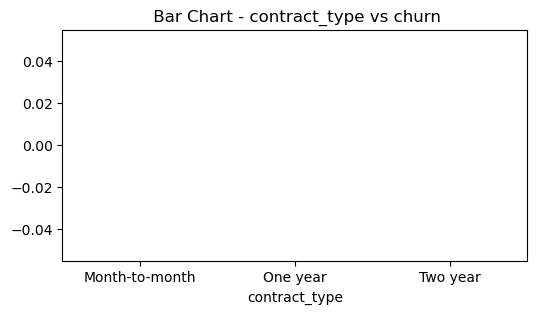

ValueError: No data; `observed` has size 0.

In [18]:
analyze_contract_type(train, 'contract_type', 'churn')

In [ ]:
> There is a relationship between contract type and whether or not someone churned
- Customers with longer contracts are loyal.
- This makes sense considering the relationship between churn and tenure.

In [19]:
def analyze_contract_type(df, column, target_column):
    '''
    Function takes in DataFrame, the contract type column name, and the target variable column name.
    Returns: Printed contingency table, a bar chart showing contract type  vs. churn, and the results of the chi sqaured test. 
    '''
    
    
    # Calculate churn rates
    churn_rates = df.groupby('contract_type')['churn'].mean()
   
   
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], df[target_column])

    # Plot a bar chart (count plot)
    plt.figure(figsize=(6, 3))
    sns.countplot(x=column, hue=target_column, data=df, palette='pastel')


    plt.title(f' Bar Chart - {column} vs {target_column}')
    plt.show()

    # Perform a chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Display the contingency table
    print("Contingency Table:")
    print(contingency_table)
    
    # Display the chi-squared test results
    print("\nChi-squared test:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")